# Neural Networks

* Neural network is a function which takes a vector $\mathbf x$ with $n$ elements and produces an output $\mathbf y$ with $n_{ \mathrm out}$ elements
* Assume to have have $N$ samples of $\mathbf x$ and $\mathbf y$.
* For neural networks is it generally required to have a large sample

In [1]:
using Test
using PyPlot
using Random

In [2]:
N = 1000; # number of samples
n = 2; # number of features
nout = 2
x = randn(n,N)
y = zeros(nout,N)

2×1000 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

Let's try some random function

In [3]:
f(x) = x[1,:] .+ x[2,:] + 2. ./ (x[1,:].^2 .+ x[2,:].^2 .+ 0.3);
y[1,:] =f(x);

y[2,:] = x[1,:] .- x[2,:];

Plot this function

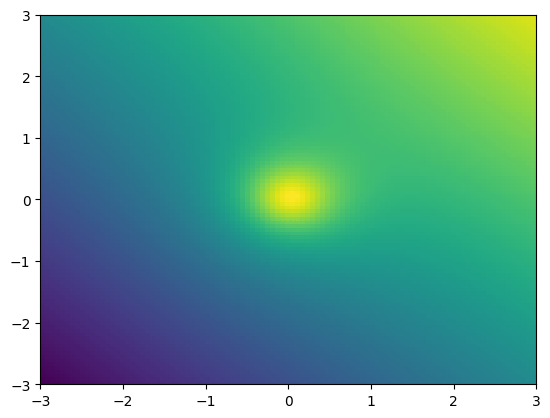

In [4]:
xmin = [-3, -3]
xmax = [3, 3]

gx = [px for px = range(xmin[1],stop=xmax[1],length=100), py = range(xmin[2],stop=xmax[2],length=100)]
gy = [py for px = range(xmin[1],stop=xmax[1],length=100), py = range(xmin[2],stop=xmax[2],length=100)]

gf = reshape(f([gx[:]'; gy[:]']),size(gx))
pcolor(gx,gy,gf);

Define the number of neurons in each layer

Observations

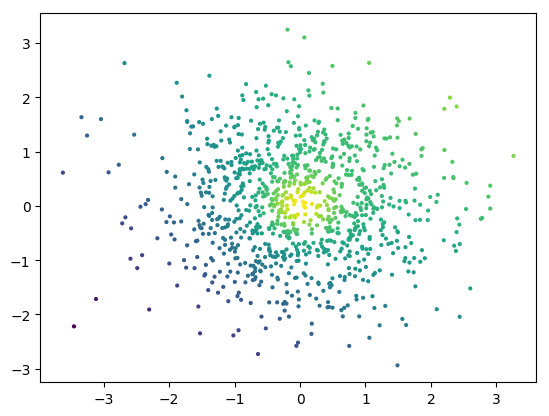

PyObject <matplotlib.collections.PathCollection object at 0x7f3efd2d84a8>

In [5]:
#plot(x[1,:],x[2,:],"k."; markersize = 1)
scatter(x[1,:],x[2,:],4,y[1,:])


In [6]:
Random.seed!(123)
nneurons = [n,20,20,nout]


#w = [randn(10,n),randn(nout,10)]
#b = [randn(10), randn(nout)]

4-element Array{Int64,1}:
  2
 20
 20
  2

Initialize the weights and biases

In [7]:
function randnomwb(nneurons)
  w = Matrix{Float64}[]
  b = Vector{Float64}[]

  for i = 2:length(nneurons)
    push!(w,randn(nneurons[i],nneurons[i-1]))
    push!(b,randn(nneurons[i]))    
  end
    
  return w,b
end

w,b = randnomwb(nneurons);

In [8]:
size.(b)

3-element Array{Tuple{Int64},1}:
 (20,)
 (20,)
 (2,) 

Activation functions and their derivative

In [9]:
sigmoid(x) = 1/(1+exp(-x))
∇sigmoid(x) = exp(-x)/(1+exp(-x))^2

@show ∇sigmoid(0), (sigmoid(0.001) - sigmoid(0)) / 0.001

relu(x) = max(x,zero(x))
∇relu(x) = (x > 0 ? one(x) : zero(x))

(∇sigmoid(0), (sigmoid(0.001) - sigmoid(0)) / 0.001) = (0.25, 0.2499999791666374)


∇relu (generic function with 1 method)

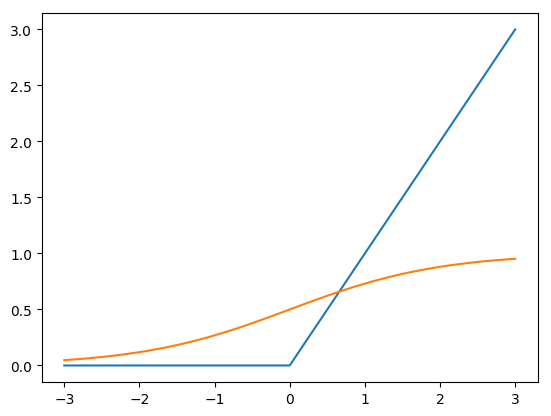

In [10]:
xplot = -3:0.1:3
plot(xplot,relu.(xplot))
plot(xplot,sigmoid.(xplot));

The loss functions defines how well of neural network reproduces the data
* for a regression problem the loss is often the L2 norm, representing how close the prediction $\mathbf y'$ are to the observations $\mathbf y$:

$$
J(\mathbf y') = || \mathbf y - \mathbf y' ||^2
$$

* if neural network predict probabilities, then it is common to use the negative log likelihood

In [11]:
loss(y,yp) = sum(abs2,y - yp)/length(y)
δloss(y,yp,δyp) = (sum((y - yp).^2 / length(y)), -2*δyp ⋅ (y - yp)/length(y))

δloss (generic function with 1 method)

In [12]:
size(x), size(w[1])

((2, 1000), (20, 2))

In [13]:

layer(w,b,x) = w*x .+ b
δlayer(w,b,x,δw,δb,δx) = (w*x .+ b, δb .+ (δw*x + w*δx))

∇identity(x) = one(x)


const funs = [sigmoid,sigmoid,identity]
const ∇funs = [∇sigmoid,∇sigmoid,∇identity]



function predict(w::Vector{TA},b,x) where TA
    K = length(b)+1    
    yp = Vector{TA}(undef,K)
    
    yp[1] = x    
    for i = 1:K-1
       yp[i+1] = funs[i].(layer(w[i],b[i],yp[i]))
    end
    
    return yp[end]
end

function cost(w,b,x,y)    
    yp = predict(w,b,x)
    return loss(y,yp)
end

cost(w,b,x,y)

14.776204541005532

In [14]:
eps = 1e-4

δb = [eps*randn(size(tmp)) for tmp in b]
δw = [eps*randn(size(tmp)) for tmp in w]

b2 = [tmp + δtmp for (tmp,δtmp) in zip(b,δb)]
w2 = [tmp + δtmp for (tmp,δtmp) in zip(w,δw)]

J2 = cost(w2,b2,x,y) 

14.779633358120842

In [15]:
cost(w,b,x,y)

14.776204541005532

In [16]:
δc_diff = (cost(w2,b2,x,y) 
         - cost(w,b,x,y)) / eps

function δpredict(w,b,x,δw,δb)
    K = length(b)+1
    
    yp = copy(x)
    δyp = zeros(size(x))
    for i = 1:K-1
       yp, δyp = δlayer(w[i],b[i],yp,δw[i],δb[i],δyp)
       δyp = ∇funs[i].(yp) .* δyp
       yp = funs[i].(yp) 
    end
    
    return yp,δyp 
end

function δcost(w,b,x,y,δw,δb)
    yp, δyp = δpredict(w,b,x,δw,δb)
    return δloss(y,yp,δyp)
end


J,δJ =  δcost(w,b,x,y,δw,δb)

@test δc_diff ≈ δJ/eps rtol=1e-2
#@show δc_diff
#@show δJ/eps

Test Passed

Adjoint

In [17]:
∂J = 1.

t1 = ∂J * δcost(w,b,x,y,δw,δb)[2]

function adj_loss(y,yp,∂J)
    ∂yp = -2 * (y - yp) * ∂J / length(y)
end


function adj_layer(w,b,x,∂yp)
    ∂b = sum(∂yp,dims=2)[:,1]
    ∂w = (∂yp) * x'
    ∂x = w' * ∂yp    
    return ∂w,∂b,∂x
end


function adj_cost(w::Vector{Matrix{T}},b::Vector{Vector{T}},x,y,δJ) where T
    N = length(b)
    yp = Vector{Matrix{T}}(undef,N+1)
    ∂yp = Vector{Matrix{T}}(undef,N+1)
    ∂w = Vector{Matrix{T}}(undef,N)
    ∂b = Vector{Vector{T}}(undef,N)
    
    # prediction - foreward
    yp[1] = x
    for i = 1:N
      yp[i+1] = funs[i].(layer(w[i],b[i],yp[i]))
    end
    
    # back-propagation
    # now everything in reverse
    ∂yp[N+1] = adj_loss(y,yp[N+1],∂J)
    
    for i = N:-1:1
       ∇act = ∇funs[i].(w[i]*yp[i] .+ b[i])
       ∂yp[i+1] = ∇act .* ∂yp[i+1]
       ∂w[i],∂b[i],∂yp[i] = adj_layer(w[i],b[i],yp[i],∂yp[i+1])
    end
    
    return ∂w,∂b
end


∂w,∂b = adj_cost(w,b,x,y,∂J)

t2 = 0.
for i = 1:length(b)
    t2 = t2 + ∂w[i] ⋅ δw[i] + ∂b[i] ⋅ δb[i]
end

@test t1  ≈ t2

Test Passed

Gradient descent


In [18]:
@show cost(w,b,x,y)

cost(w, b, x, y) = 14.776204541005532


14.776204541005532

In [19]:
@show cost(w,b,x,y)

η = 0.2 # learning rate

# compute the gradient
∂w,∂b = adj_cost(w,b,x,y,1.)

# update weights and biases
for i = 1:length(w)
    w[i] = w[i] - η * ∂w[i]
    b[i] = b[i] - η * ∂b[i]
end
@show cost(w,b,x,y)


cost(w, b, x, y) = 14.776204541005532
cost(w, b, x, y) = 18.248125466154438


18.248125466154438

In [20]:
batchsize = 50
ibatch = randperm(N)[1:batchsize]

50-element Array{Int64,1}:
 971
 423
 737
 861
 138
 949
 391
 585
 693
 678
 286
 884
 233
   ⋮
 160
 742
 968
 504
 589
 673
 990
  65
 258
  22
 674
  10

In [21]:
@show cost(w,b,x,y)
Niter = 1000
η = 0.2 # learning rate
C = zeros(Niter+1)


for k = 1:Niter
    C[k] = cost(w,b,x,y)
    
    # compute the gradient
    ∂w,∂b = adj_cost(w,b,x,y,1.)
    
    # update weights and biases
    for i = 1:length(w)
      w[i] = w[i] - η * ∂w[i]
      b[i] = b[i] - η * ∂b[i]
    end  
end
C[Niter+1] = cost(w,b,x,y)

cost(w, b, x, y) = 18.248125466154438


0.09496836655089366

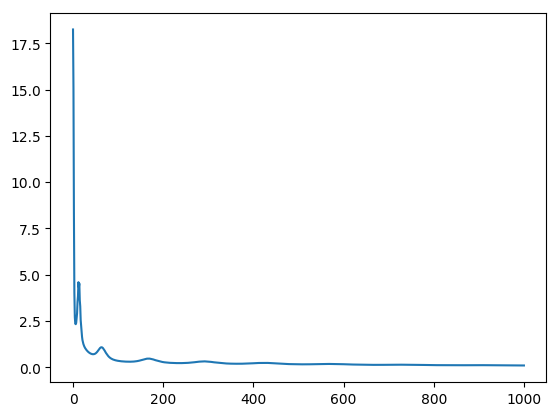

In [22]:
plot(C);

In [23]:
w,b = randnomwb(nneurons)

@show cost(w,b,x,y)
Niter = 1000
η = 0.2 # learning rate
C = zeros(Niter+1)


for k = 1:Niter
    C[k] = cost(w,b,x,y)
    
    
    ibatch = randperm(N)[1:batchsize]
    
    # compute the gradient
    ∂w,∂b = adj_cost(w,b,x[:,ibatch],y[:,ibatch],1.)
    
    # update weights and biases
    for i = 1:length(w)
      w[i] = w[i] - η * ∂w[i]
      b[i] = b[i] - η * ∂b[i]
    end  
end
C[Niter+1] = cost(w,b,x,y)

cost(w, b, x, y) = 7.976902819603099


0.11795932321871248

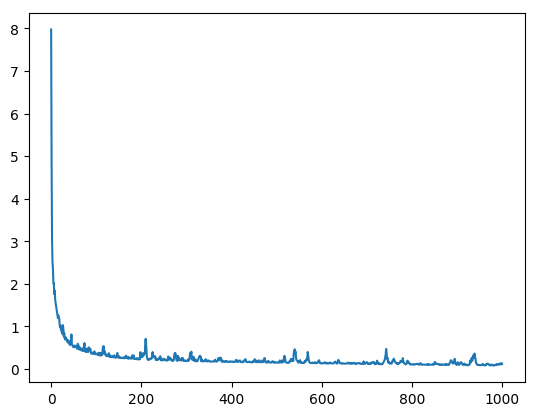

In [24]:
plot(C);

In [25]:
predict(w,b,x)

2×1000 Array{Float64,2}:
 1.16643   0.405805   2.31363   0.20205   …   1.08806  3.15328  2.60165
 0.245986  3.3755    -1.57567  -0.381486     -2.04838  1.74503  1.43657

In [26]:
y

2×1000 Array{Float64,2}:
 0.629848  0.427401   1.71167  -0.112971  …   0.735421  3.20336  2.29792
 0.168407  3.99367   -1.43504  -0.482772     -1.85848   1.8106   1.27711

In [27]:
i=1;j=1
[gx[i,j]; gy[i,j]][2,:]

1-element Array{Float64,1}:
 -3.0

In [28]:
size(x)

(2, 1000)

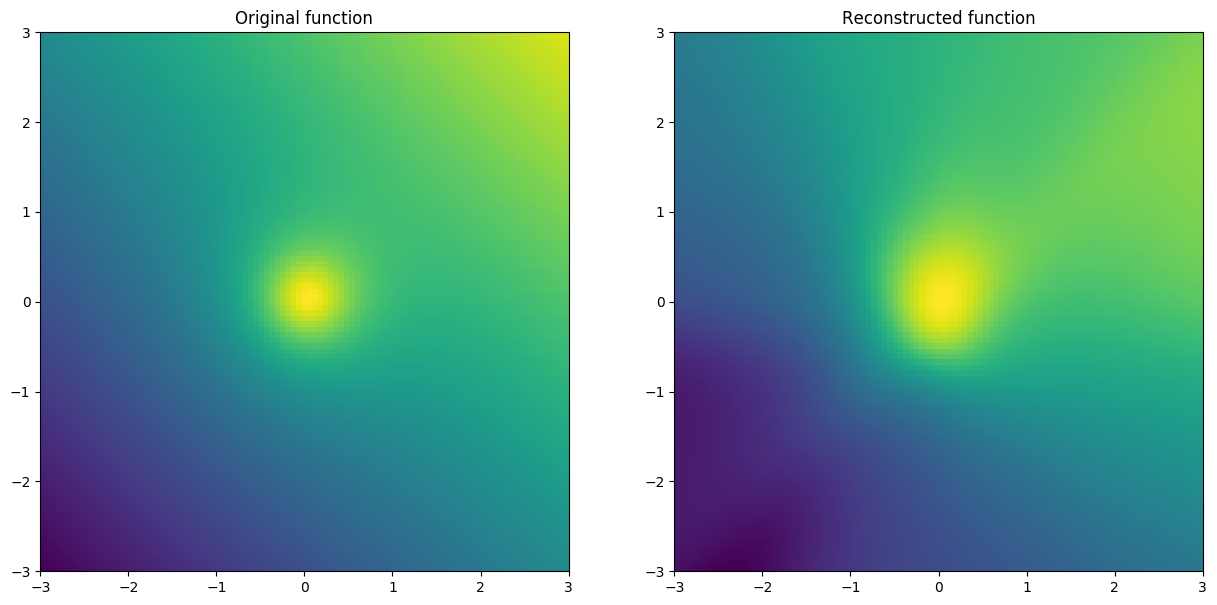

In [29]:
gf2 = zeros(size(gx))
for j = 1:size(gx,2)
   for i = 1:size(gx,1)
        gf2[i,j] = predict(w,b,reshape([gx[i,j]; gy[i,j]],(2,1)))[1]
    end
end

fig = figure(figsize=(15,7))
subplot(1,2,1)
pcolor(gx,gy,gf)
title("Original function")

subplot(1,2,2)
pcolor(gx,gy,gf2);
title("Reconstructed function");


Can we avoid to write gradient and ajoint of your neural network by-hand?
* yes we can using e.g. ReverseDiff
* However, we cannot use a vector of vectors (`b`) and vectors of matrices (`w`).
* We have to pack (or `flatten`), all these quantities into a long vector

In [30]:
#Pkg.add("ReverseDiff")

In [31]:
packwb(w,b) = cat(b..., collect.(Iterators.flatten.(w))..., dims = 1)

packwb (generic function with 1 method)

In [32]:
wb = packwb(w,b)
size.(b)
wb

522-element Array{Float64,1}:
 -2.10914694019175   
 -1.0243212326625117 
  0.2585927166208272 
 -1.1978005189152956 
  0.3648820118546103 
  0.20571614299138902
  0.44690145829530886
 -0.3086369009627709 
 -1.9899457005330652 
  0.8741633892510121 
  1.8062375205683978 
  0.5383253985464443 
 -2.0072222883878714 
  ⋮                  
  0.7641886831350363 
 -0.7759393821919192 
 -0.03386735724174157
 -1.62775255184681   
  1.7905385609341762 
 -0.3717269216578763 
 -1.2332224047966505 
 -0.5260997941862393 
  0.21607837937961977
  1.3237454798130746 
 -0.2378553066570378 
  0.39454428379188494

And we need to provide the inverse function

In [33]:
function unpackwb(wb::TA,nneurons) where TA
    b = TA[]
    w = []
    j = 0
    for i = 1:length(nneurons)-1
        push!(b,wb[j+1:j+nneurons[i+1]])
        j += +nneurons[i+1]
    end
    for i = 1:length(nneurons)-1
        push!(w,reshape(wb[j+1:j + nneurons[i+1] * nneurons[i]],(nneurons[i+1],nneurons[i])))
        j += +nneurons[i] * nneurons[i+1]
    end
    
    return w,b
end
  

unpackwb (generic function with 1 method)

Packing and unpacking should return the original data

In [34]:
  
w2, b2 = unpackwb(wb,nneurons)
@test b2 == b

Test Passed

In [35]:
@test w2 == w

Test Passed

In [36]:
nneurons

4-element Array{Int64,1}:
  2
 20
 20
  2

In [37]:
size.(w)

3-element Array{Tuple{Int64,Int64},1}:
 (20, 2) 
 (20, 20)
 (2, 20) 

In [38]:
using ReverseDiff: GradientTape, GradientConfig, gradient, gradient!, compile

In [39]:
function costwb(wb)
    w,b = unpackwb(wb,nneurons)
    return cost(w,b,x,y)
end

const f_tape = GradientTape(costwb, (wb,))
const compiled_f_tape = compile(f_tape)
#extrema(results)

function adj_cost2(w,b)
    wb = packwb(w,b)
    results = (similar(wb),)
    gradient!(results, compiled_f_tape, (wb,))
    return unpackwb(results[1],nneurons)
end
#maximum(gradient(costwb,(wb,))[1])

#results = gradient(costwb,(wb,))[1]

grad = (similar(wb),)

#f_tape2 = GradientTape(costwb, (wb,))
gradient!(grad, compiled_f_tape, (wb,))


([0.00558596, 0.0852401, 0.0414267, 0.0356749, 0.0297448, 0.0475382, 0.00907498, 0.0361964, -0.0765979, 0.0814357  …  0.210837, 0.0757326, 0.00474251, 0.00165198, 0.0833618, 0.0297118, 0.138308, 0.0482513, 0.00179478, 0.00117985],)

In [40]:
e = zeros(size(wb))
e[1,1] = 1

@test (costwb(wb+eps*e) - costwb(wb))/eps ≈ grad[1][1] rtol=1e-3


Test Passed

In [41]:
rwb = randn(size(wb))

@test (costwb(wb + eps*rwb) - costwb(wb - eps*rwb))/(2eps) ≈ sum(rwb .* grad[1]) rtol=1e-3


Test Passed

In [42]:
∂w,∂b = adj_cost(w,b,x,y,1.)
∂w2,∂b2 = adj_cost2(w,b)

@test ∂w ≈ ∂w2
@test ∂b ≈ ∂b2


Test Passed